List of unknowns:

- Object position ($[x_{obj}, y_{obj}, z_{obj}]$) (default: )
- Rotation centre ($[x_{rot}, y_{rot}, z_{rot}]$) (default: )
- Na density ($\rho_{Na}$) (default: 0.971 g/cm<sup>3</sup>)
- ZrO2 density ($\rho_{ZrO_2}$) (default: 5.68 g/cc)

<!-- - Source position ($[x_{src}, y_{src}, z_{src}]$) (default: )
- Detector position ($[x_{det}, y_{det}, z_{det}]$) (default: )
- Object orientation ($[\alpha_x, \alpha_y, \alpha_z]$) (default: ) -->

In [1]:
import os, sys, time
import numpy as np

import matplotlib.pyplot as plt

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib

# from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen


K3D is not install, you won't be able to visualise the 3D scene using k3D
spekpy is not install, you won't be able to load a beam spectrum using spekpy
SimpleGVXR 2.0.6 (2023-05-23T20:42:48) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.6 (2023-05-23T20:43:44) [Compiler: Microsoft Visual Studio] on Windows


In [2]:
current_folder = str(globals()['_dh'][0])

In [3]:
sod = 32.4179
sdd = 486.296

In [4]:
rho_Na = 0.971
rho_ZrO2 = 5.68

x_src = 0
y_src = sod
z_src = 0

x_det = 0
y_det = -(sdd - sod)
z_det = 0

x_obj = 0
y_obj = 0
z_obj = 0

alpha_x = 0 
alpha_y = 0
alpha_z = 0

x_rot = 0
y_rot = 0
z_rot = 0

In [5]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR(current_folder + "/simulation.json", "OPENGL", 3, 2)

Create an OpenGL context: 512x512


In [6]:
# Load our source properties
json2gvxr.initSourceGeometry(current_folder + "/simulation.json")
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

# gvxr.setNumberOfPhotons(4000)

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [7]:
def getAverageEnergy(k, f):
    
    avg = 0
    for energy, count in zip(k, f):
        avg += energy * count
        
    return avg / np.sum(f)

In [8]:
# spectrum_filtered, k_filtered, f_filtered, units = loadXpecgenSpectrum(230, filters=[["Cu", 1]])

# average_energy_filtered = getAverageEnergy(k_filtered, f_filtered)
# print("Average energy:", average_energy_filtered, units)

In [9]:
# Load our detector
json2gvxr.initDetector(current_folder + "/simulation.json")
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [716, 716]
	Detector number of pixels: [716, 716]
	Pixel spacing: [150, 150, 'um']


In [10]:
# Load our samples
json2gvxr.initSamples(current_folder + "/simulation.json", verbose=0)

gvxr.setDensity("kernel", rho_ZrO2, "g/cm3")
gvxr.setDensity("residual", rho_Na, "g/cm3")

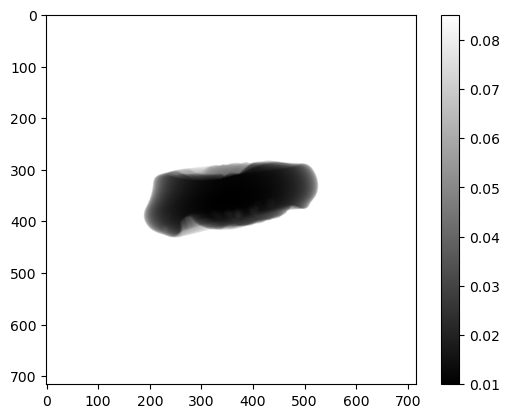

In [11]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [12]:
import cma
from tifffile import imread, imwrite



In [13]:
total_nb_projs = 544
angular_span = 360
angular_step = 360 / 544

fnames_images = []
angles = []

for i in range(total_nb_projs):
    angles.append(i*angular_step)
    fnames_images.append(current_folder + "/../Proj/img_" + "{:05d}".format(i) + ".tif")    

In [14]:
def setNumberOfProjections(n):
    global nb_projs_in_fitness, ref_images, crop_ref_images, fitness_angles, fitness_fnames, test_images

    nb_projs_in_fitness = n
    
    ref_images = []
    fitness_angles = []
    fitness_fnames = []

    for i in range(nb_projs_in_fitness):
        index = int(i / nb_projs_in_fitness * total_nb_projs / 2)
        print(i, angles[index], fnames_images[index])
        ref_images.append(imread(fnames_images[index]))
        fitness_angles.append(angles[index])
        fitness_fnames.append(fnames_images[index])

    ref_images = np.array(ref_images, dtype=np.single)
    ref_images -= ref_images.mean()
    ref_images /= ref_images.std()

    fitness_angles = np.array(fitness_angles, dtype=np.single)

    test_images = np.zeros(ref_images.shape, dtype=np.single)
    
    crop_ref_images = ref_images[:, 211:470, 100:600]
    crop_ref_images -= crop_ref_images.mean()
    crop_ref_images /= crop_ref_images.std()

In [15]:
def displayResult(x):
    transform(x)
    
    ZNCC = 100 * (crop_ref_images * crop_test_images).mean()
    print("Overall ZNCC:", "{:.4f}".format(ZNCC) + "%")
    
    for i, (angle, fname) in enumerate(zip(fitness_angles, fitness_fnames)):
        
        ref = np.copy(crop_ref_images[i])
        test = np.copy(crop_test_images[i])

        ref -= ref.mean()
        ref /= ref.std()
        
        test -= test.mean()
        test /= test.std()
        
        ZNCC = 100 * (ref * test).mean()

        offset=1.5
        # imwrite(current_folder + "/test_" + str(i) + "tif", test_images[i])
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        plt.suptitle(fname + ", ZNCC=" + "{:.4f}".format(ZNCC) + "%")
        axs[0].imshow(ref_images[i],cmap="gray", vmin=-offset, vmax=offset)
        axs[1].imshow(test_images[i],cmap="gray", vmin=-offset, vmax=offset)
        # axs[2].imshow(np.abs(ref_images[i] - test_images[i]),cmap="gray")
        im = axs[2].imshow((ref_images[i] - test_images[i]),cmap="gray", vmin=-offset, vmax=offset)
        cbar = fig.colorbar(im)
        
        for ax in axs:
            ax.set_xlim([100, 600])
            ax.set_ylim([211, 470])

        fig = plt.figure(figsize=(10, 4))
        plt.plot(crop_ref_images[i][crop_ref_images.shape[1] // 2, :], label="Experimental")
        plt.plot(crop_test_images[i][crop_ref_images.shape[1] // 2, :], label="Simulated")
        plt.legend()
        plt.show()    

In [16]:
setNumberOfProjections(2)

0 0.0 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00000.tif
1 90.0 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00136.tif


In [17]:
def transform(x):
    
    global test_images, fitness_angles, crop_test_images
    backup = gvxr.getLocalTransformationMatrix("root")
    
    for i, angle in enumerate(fitness_angles):
    
        # Rotate
        gvxr.resetSceneTransformation();
        gvxr.translateNode("root", x[0], x[1], x[2], "mm")
        gvxr.rotateNode("root", angle, 0, 0, 1)        
        gvxr.translateNode("root", x[3], x[4], x[5], "mm")


        # Simulate
        test_images[i] = np.array(gvxr.computeXRayImage(), dtype=np.single)  
        
        gvxr.setLocalTransformationMatrix("root", backup)

    test_images -= test_images.mean()
    test_images /= test_images.std()

    crop_test_images = test_images[:, 211:470, 100:600]
    crop_test_images -= crop_test_images.mean()
    crop_test_images /= crop_test_images.std()    

In [18]:
def fitness(x):
    
    global ref_images, test_image, fitness_angles, nb_projs_in_fitness, crop_ref_images
    
    transform(x)
        
    return np.abs(crop_ref_images - crop_test_images).mean()
    # return np.abs(ref_images - test_images).sum() / nb_projs_in_fitness
    # return 1.0 - (ref_images * test_images).mean()

Overall ZNCC: 84.5743%


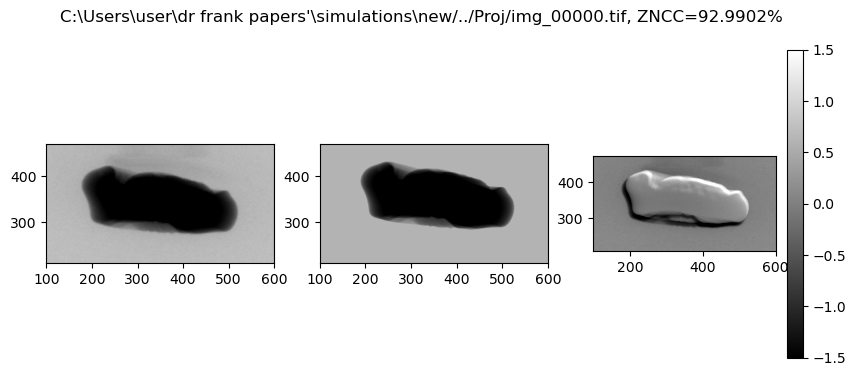

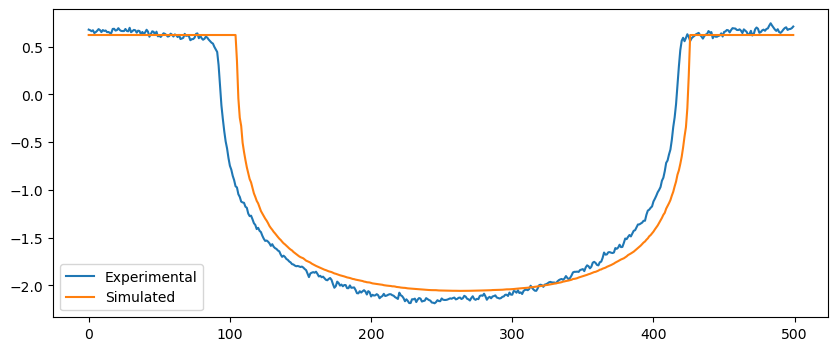

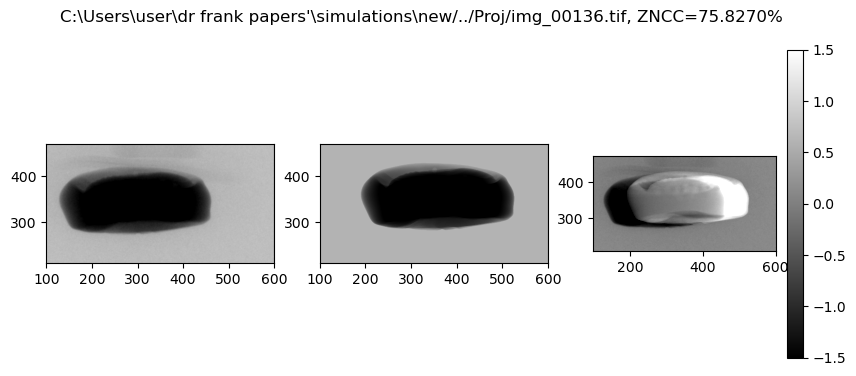

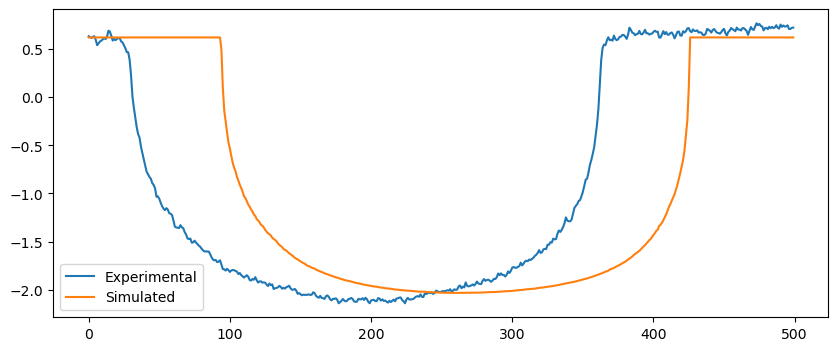

In [19]:
displayResult(6*[0.0])

In [20]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [6*[-2], 6*[2]];

if not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy([6*[0.0]], 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best1 = es.result.xbest
    np.savetxt(current_folder + "/x_best1.dat", x_best1)
else:
    x_best1 = np.loadtxt(current_folder + "/x_best1.dat")

In [21]:
print(x_best1)

[-0.07234993  0.6152048  -0.84887882 -0.00467581 -0.29117368  0.94056738]


Overall ZNCC: 99.3929%


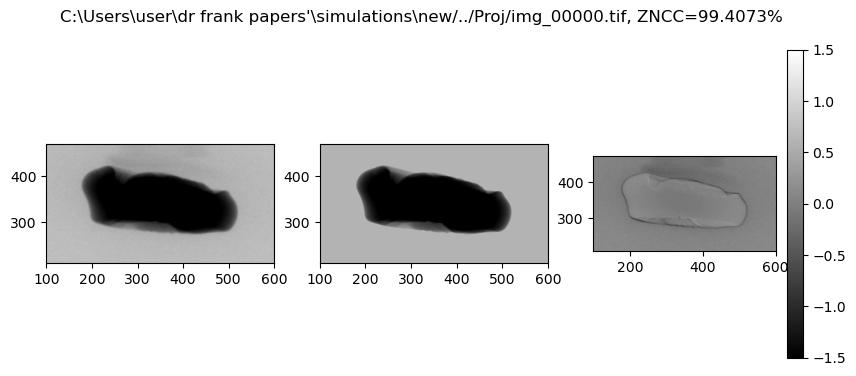

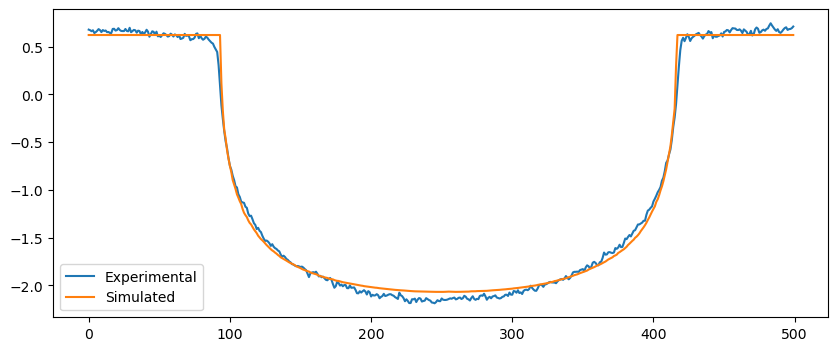

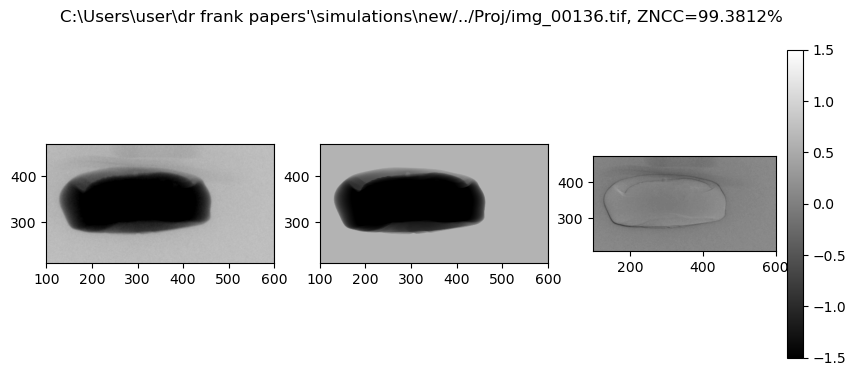

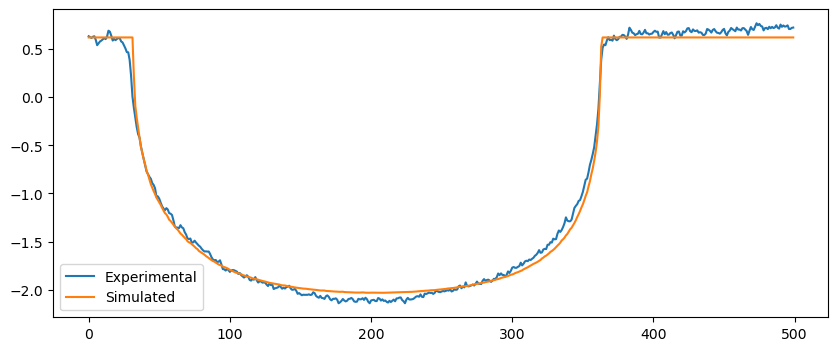

In [22]:
displayResult(x_best1)

Restart

In [23]:
setNumberOfProjections(4)

0 0.0 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00000.tif
1 45.0 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00068.tif
2 90.0 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00136.tif
3 135.0 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00204.tif


Overall ZNCC: 83.6437%


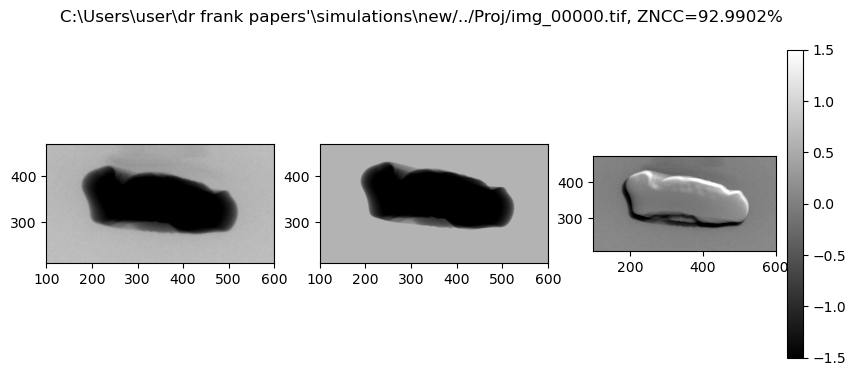

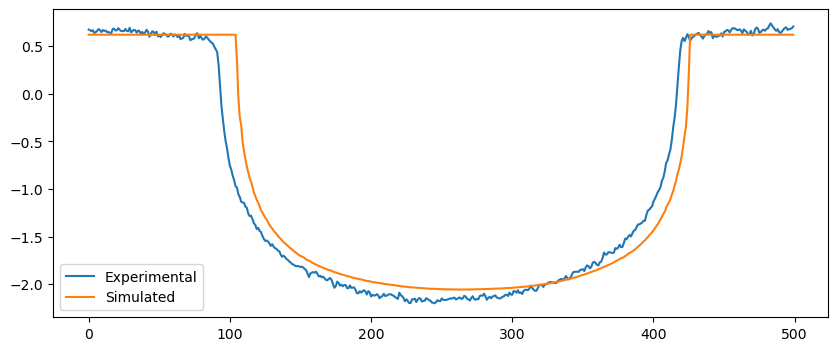

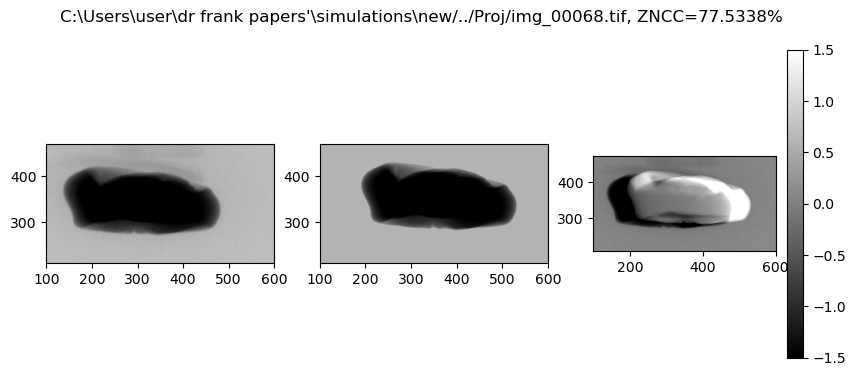

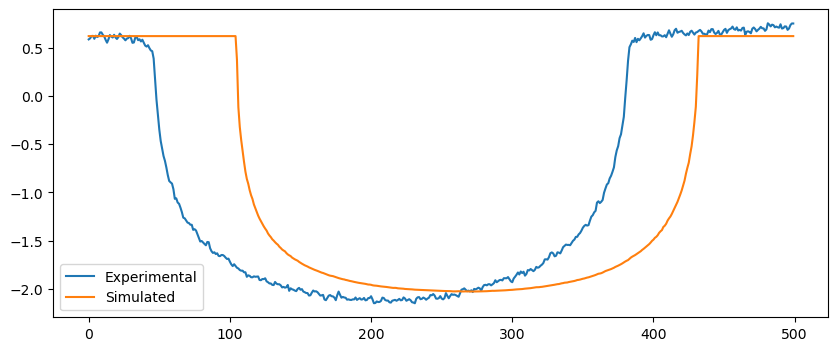

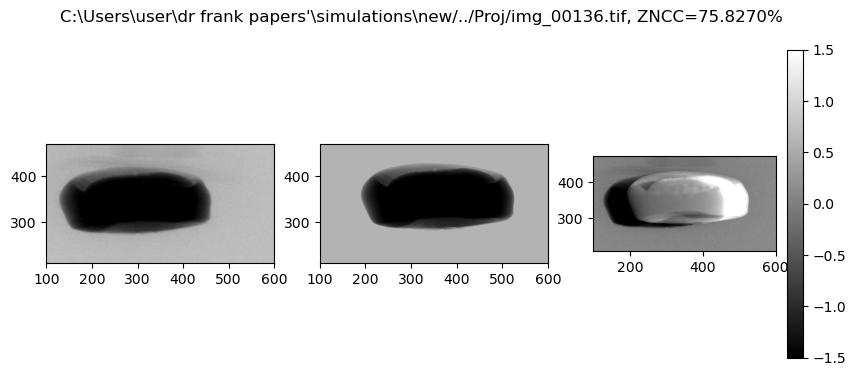

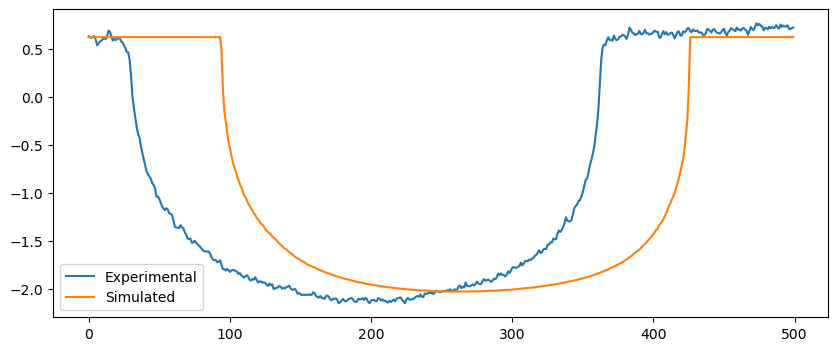

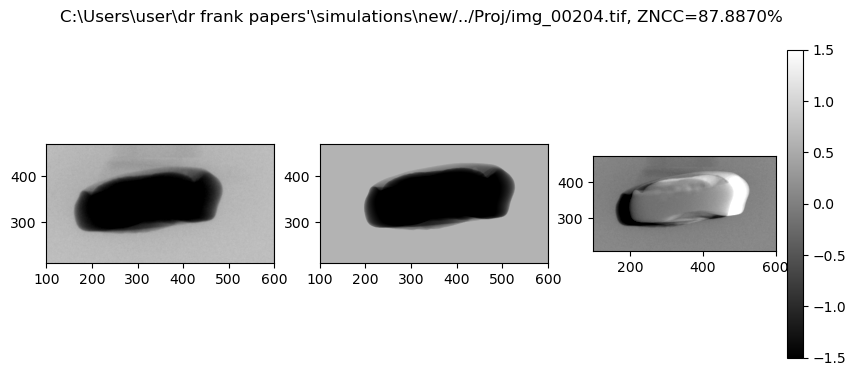

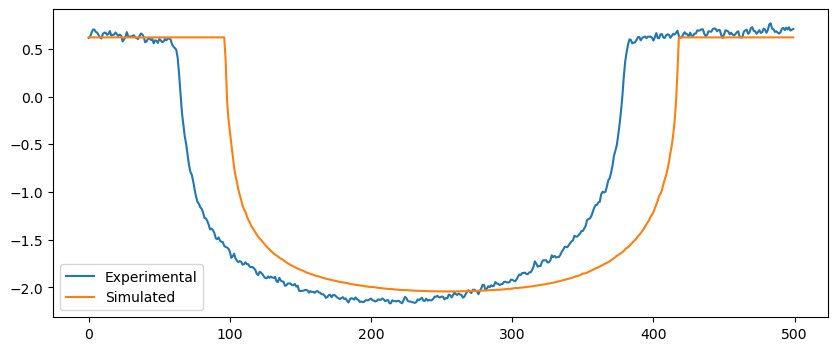

In [24]:
displayResult(6*[0.0])

Overall ZNCC: 99.3672%


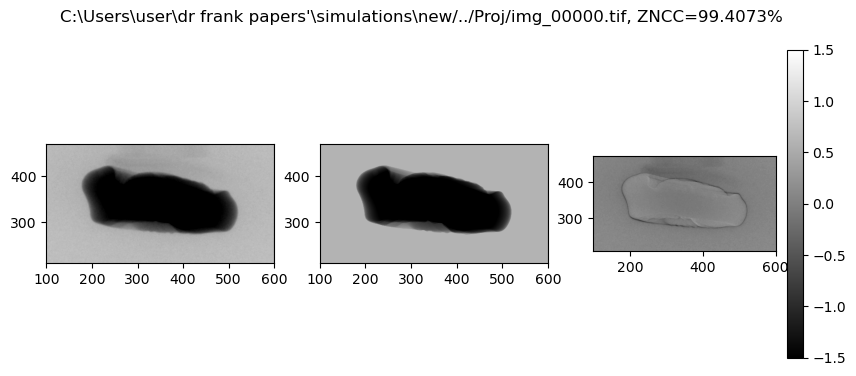

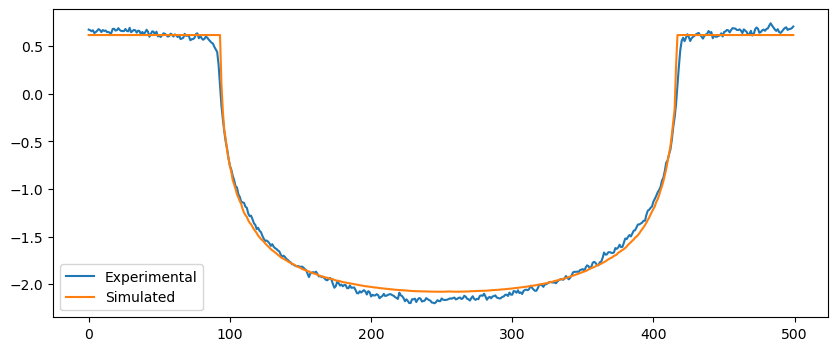

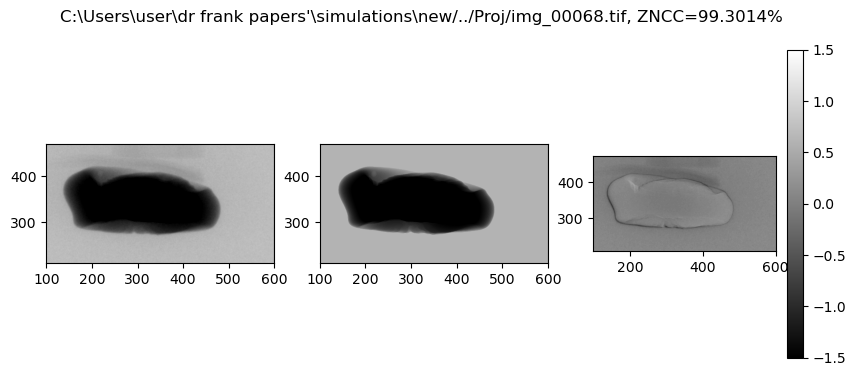

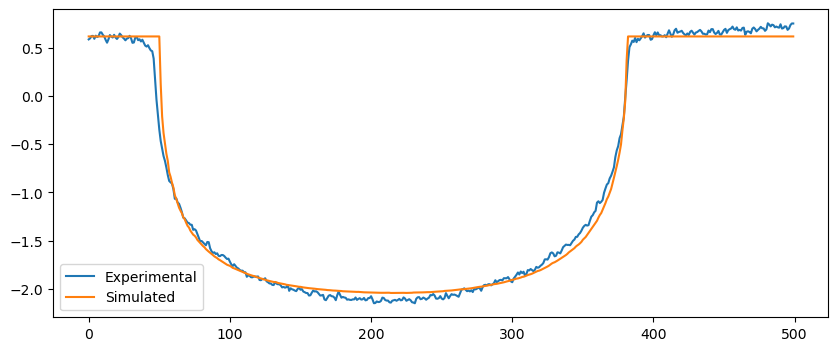

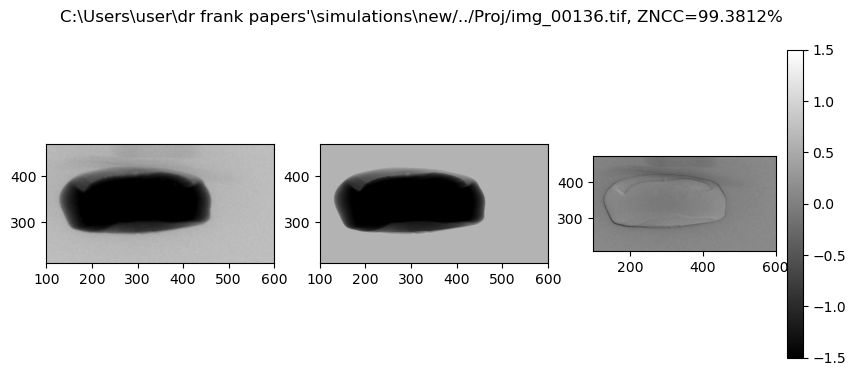

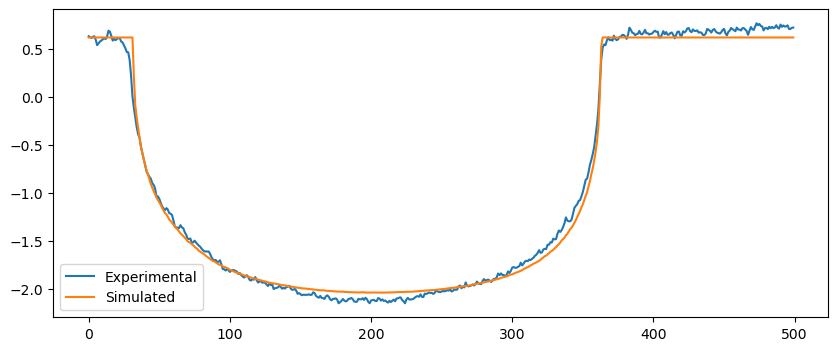

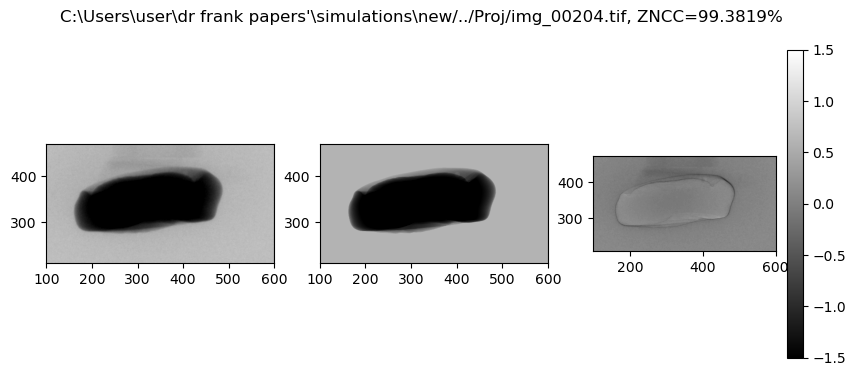

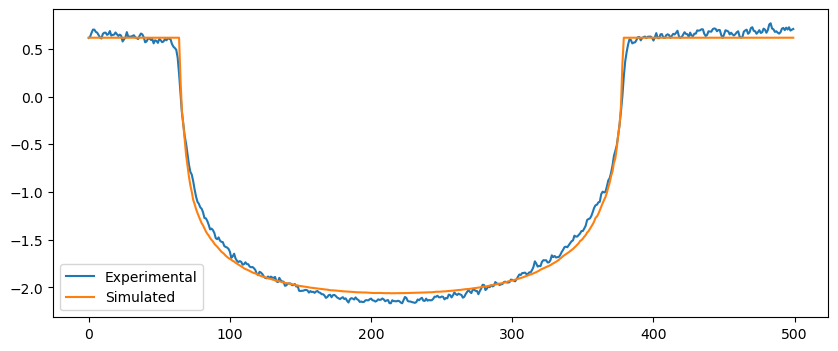

In [25]:
displayResult(x_best1)

In [26]:
if not os.path.exists(current_folder + "/x_best2.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best1, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(current_folder + "/x_best2.dat", x_best2)
else:
    x_best2 = np.loadtxt(current_folder + "/x_best2.dat")

In [27]:
print(x_best1)
print(x_best2)

[-0.07234993  0.6152048  -0.84887882 -0.00467581 -0.29117368  0.94056738]
[-0.07856483  0.63047161  0.83243383  0.0029401  -0.27937385 -0.74085789]


Overall ZNCC: 99.3816%


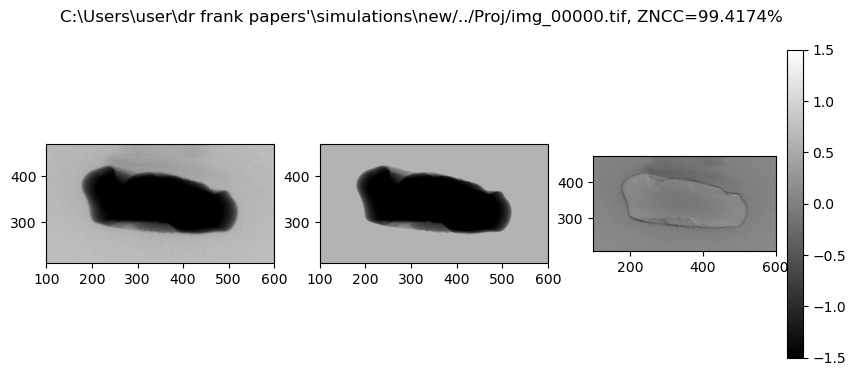

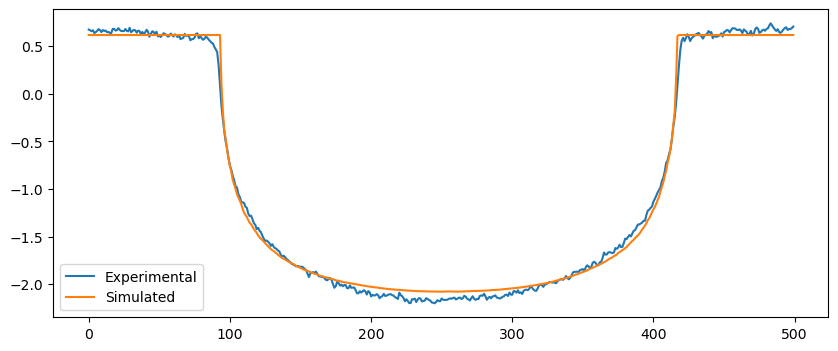

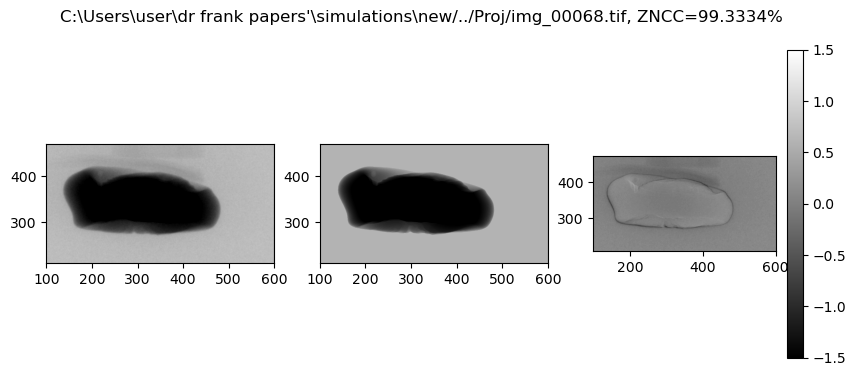

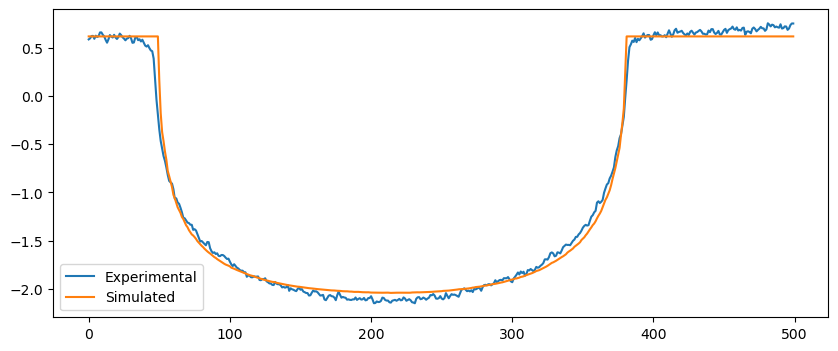

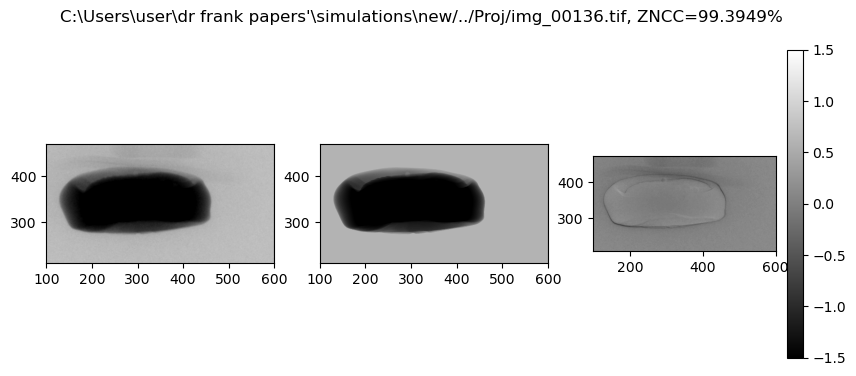

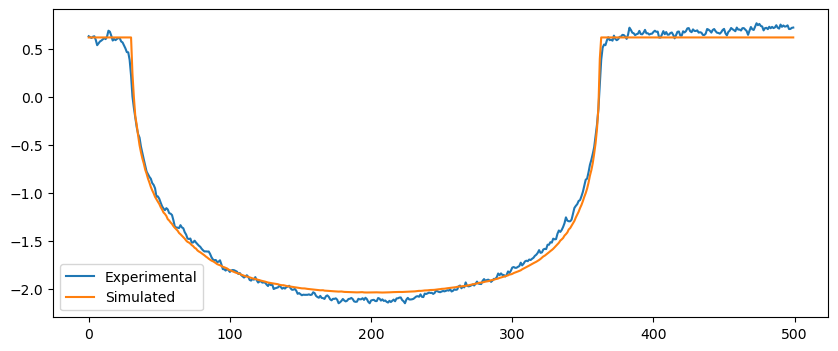

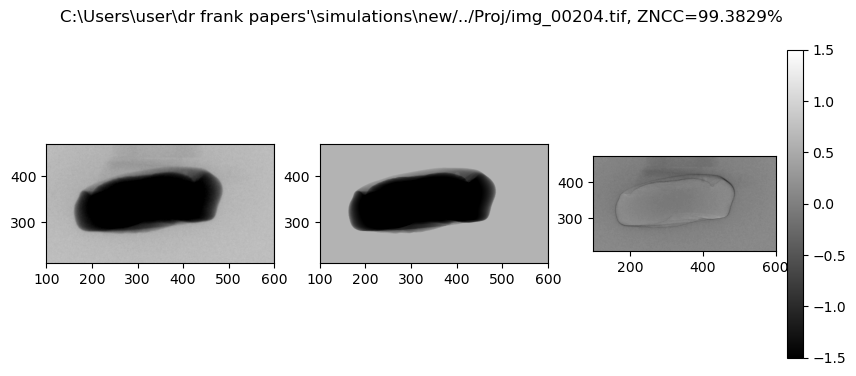

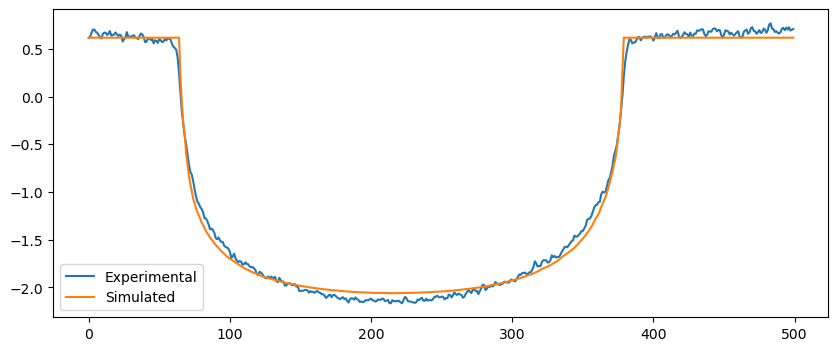

In [28]:
displayResult(x_best2)

In [29]:
def fitnessRho(x):
    
    global ref_images, test_images, crop_ref_images, crop_test_images, fitness_angles, nb_projs_in_fitness, x_best2
    
    gvxr.setDensity("kernel", x[0] * rho_ZrO2, "g/cm3")
    gvxr.setDensity("residual", x[1] * rho_Na, "g/cm3")

    transform(x_best2)
        
    return np.abs(crop_ref_images - crop_test_images).mean()
    return np.abs(ref_images - test_images).sum() / nb_projs_in_fitness
    return 1.0 - (ref_images * test_images).mean()

In [30]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [2*[0], 2*[1]];

if not os.path.exists(current_folder + "/rho_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy([2*[0.6]], 0.5, opts);
    es.optimize(fitnessRho);
    elapsed_time = time.time() - start_time

    rho_best1 = es.result.xbest
    np.savetxt(current_folder + "/rho_best1.dat", rho_best1)
else:
    rho_best1 = np.loadtxt(current_folder + "/rho_best1.dat")

In [31]:
print(rho_best1)

[0.53883427 0.30300851]


Overall ZNCC: 99.1867%


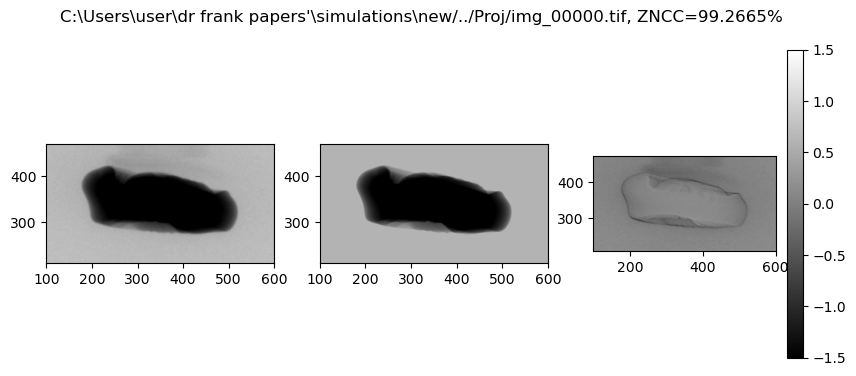

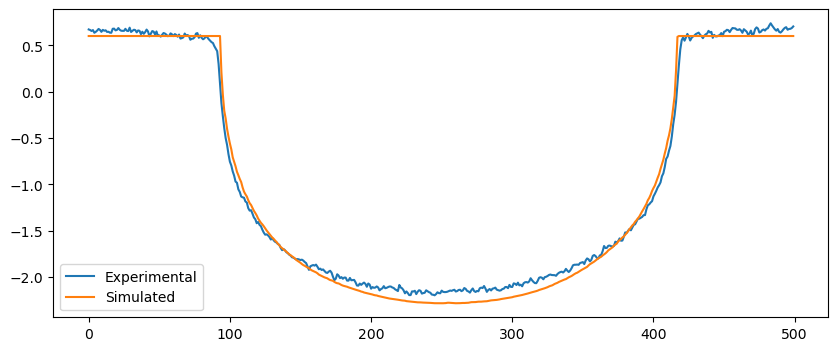

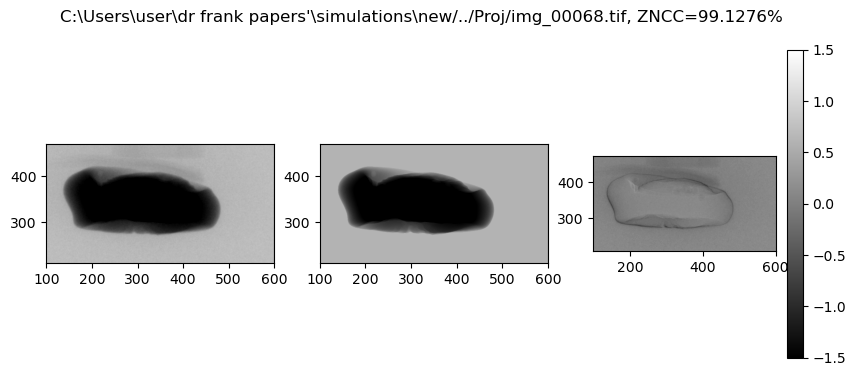

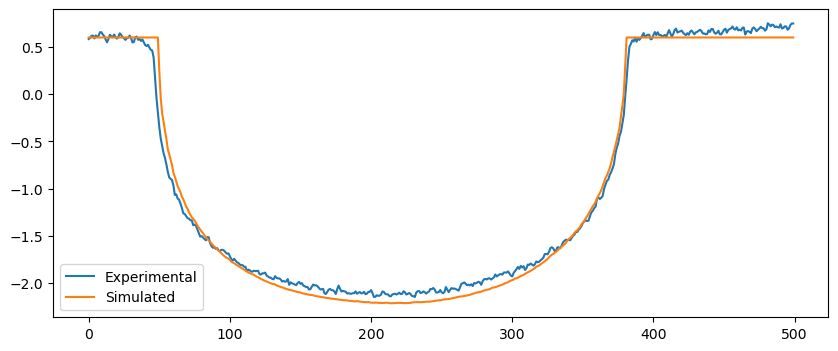

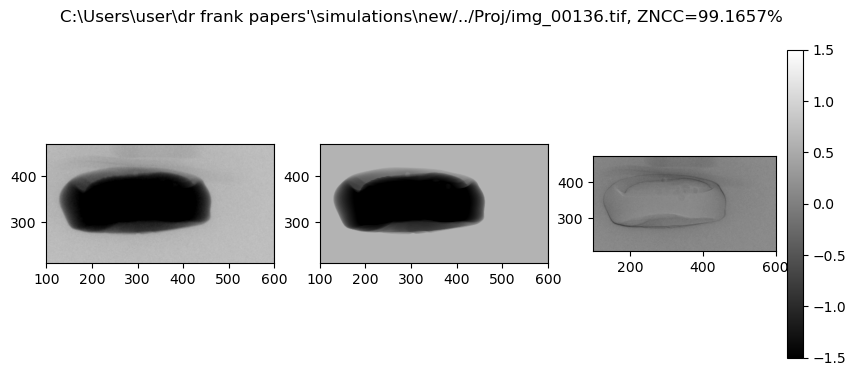

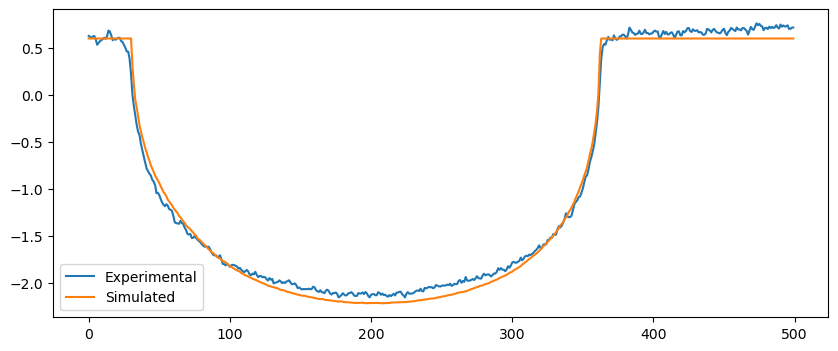

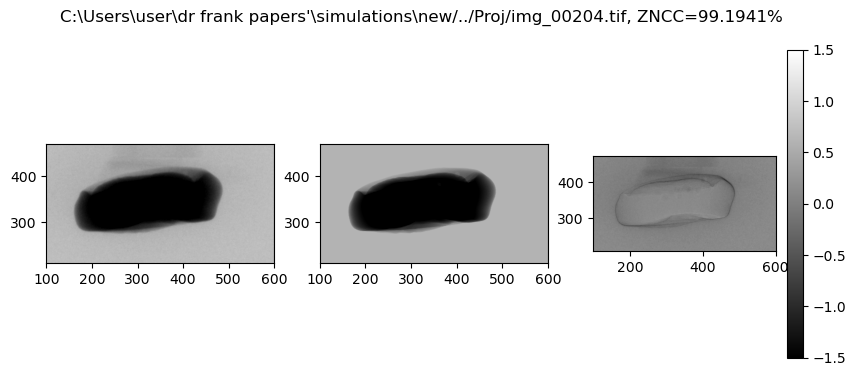

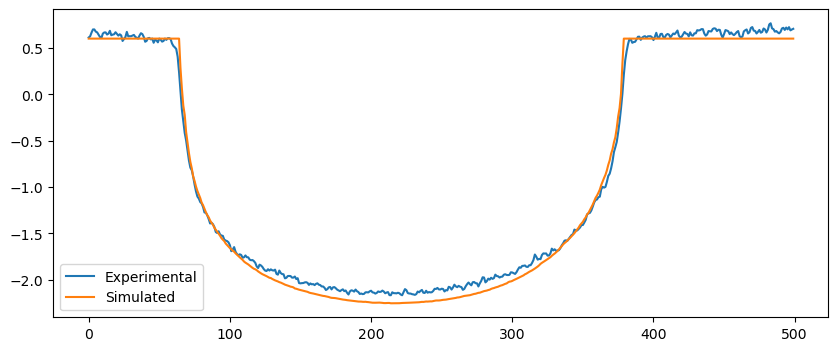

In [32]:
gvxr.setDensity("kernel", rho_best1[0] * rho_ZrO2, "g/cm3")
gvxr.setDensity("residual", rho_best1[1] * rho_Na, "g/cm3")
displayResult(x_best2)

In [33]:
opts.set('tolfun', 1e-4);
opts['tolx'] = 1e-4;
opts['bounds'] = [2*[0], 2*[1]];

if not os.path.exists(current_folder + "/rho_best2.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(rho_best1, 0.5, opts);
    es.optimize(fitnessRho);
    elapsed_time = time.time() - start_time

    rho_best2 = es.result.xbest
    np.savetxt(current_folder + "/rho_best2.dat", rho_best2)
else:
    rho_best2 = np.loadtxt(current_folder + "/rho_best2.dat")

In [34]:
print(rho_best2)

[0.52659013 0.9781389 ]


Overall ZNCC: 99.1735%


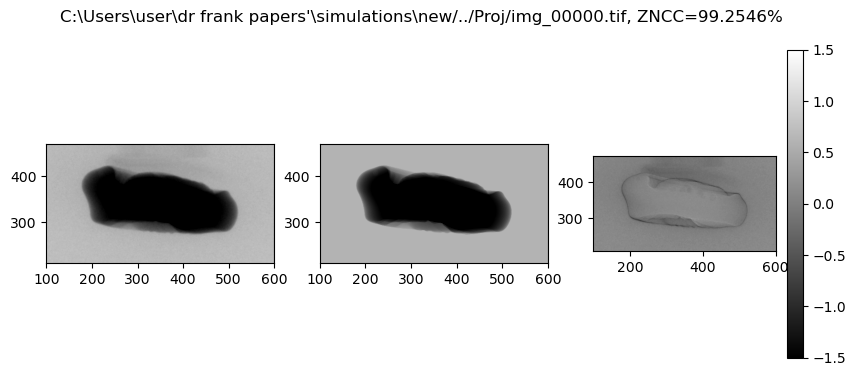

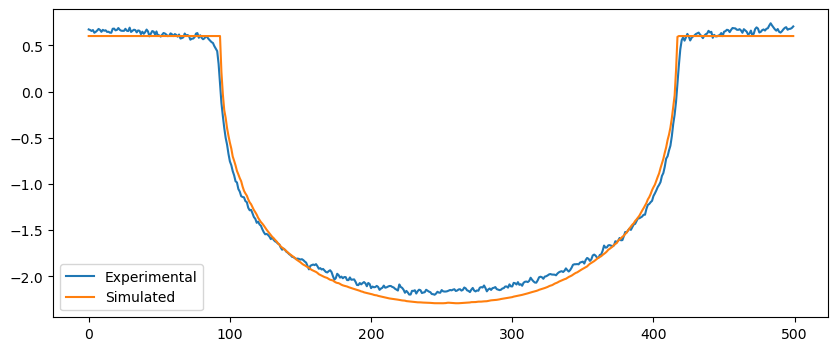

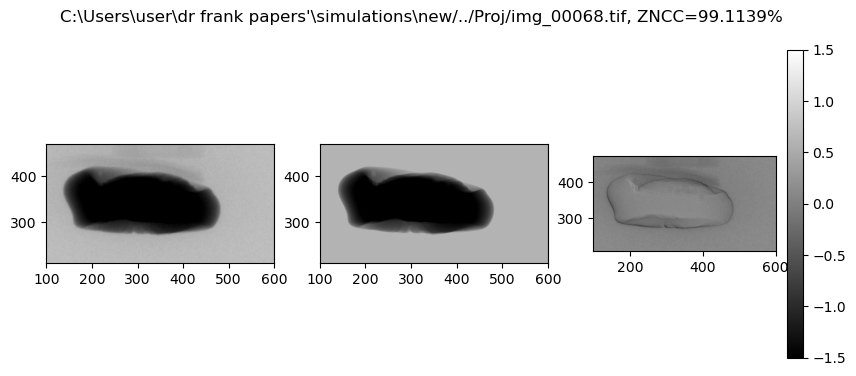

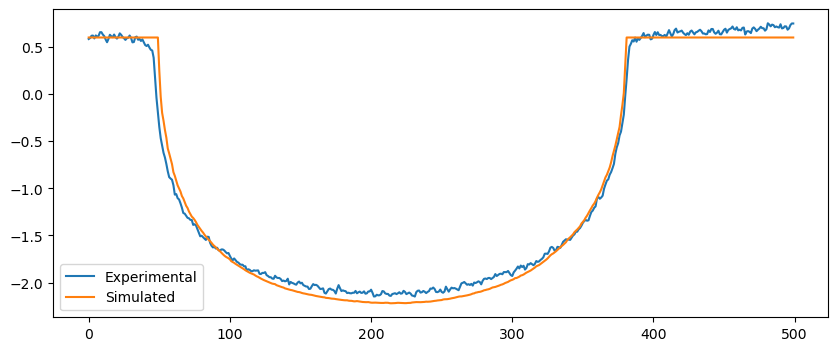

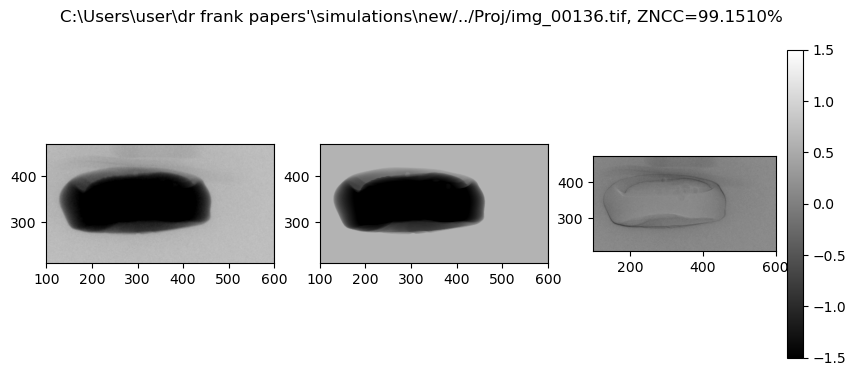

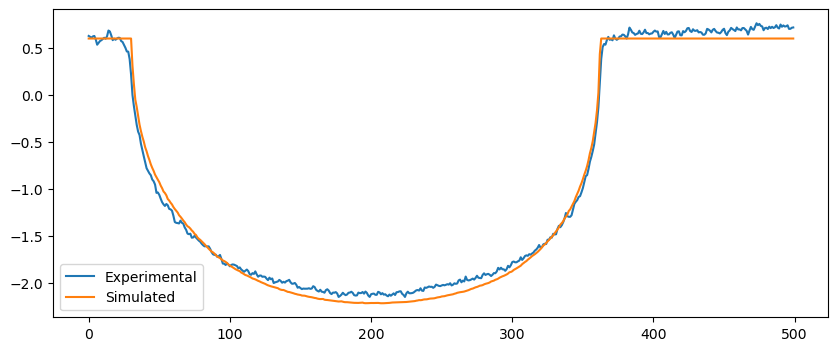

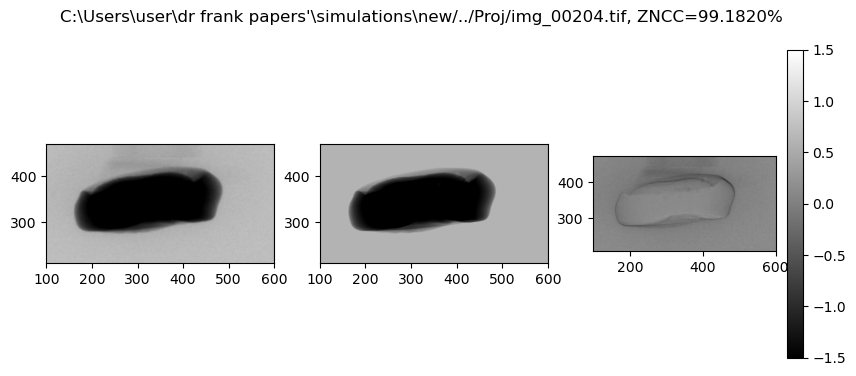

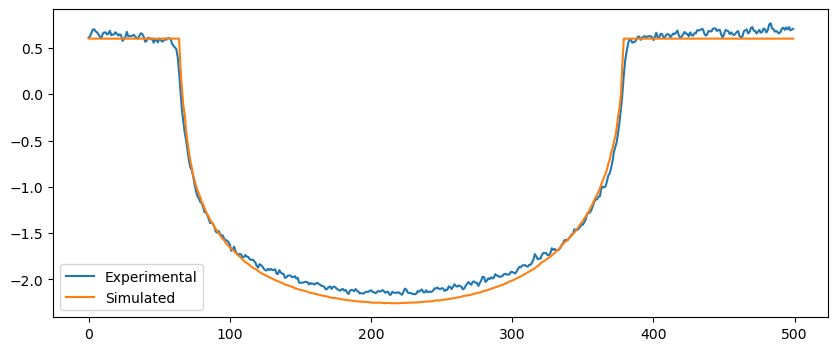

In [35]:
gvxr.setDensity("kernel", rho_best2[0] * rho_ZrO2, "g/cm3")
gvxr.setDensity("residual", rho_best2[1] * rho_Na, "g/cm3")
displayResult(x_best2)

In [36]:
setNumberOfProjections(10)

opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [6*[-2], 6*[2]];

if not os.path.exists(current_folder + "/x_best3.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best2, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best3 = es.result.xbest
    np.savetxt(current_folder + "/x_best3.dat", x_best3)
else:
    x_best3 = np.loadtxt(current_folder + "/x_best3.dat")

0 0.0 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00000.tif
1 17.86764705882353 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00027.tif
2 35.73529411764706 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00054.tif
3 53.60294117647059 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00081.tif
4 71.47058823529412 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00108.tif
5 90.0 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00136.tif
6 107.86764705882352 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00163.tif
7 125.73529411764706 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00190.tif
8 143.60294117647058 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00217.tif
9 161.47058823529412 C:\Users\user\dr frank papers'\simulations\new/../Proj/img_00244.tif


Overall ZNCC: 99.3981%


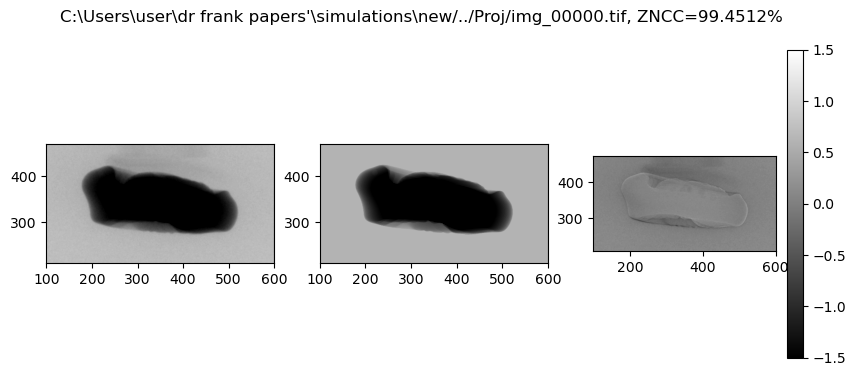

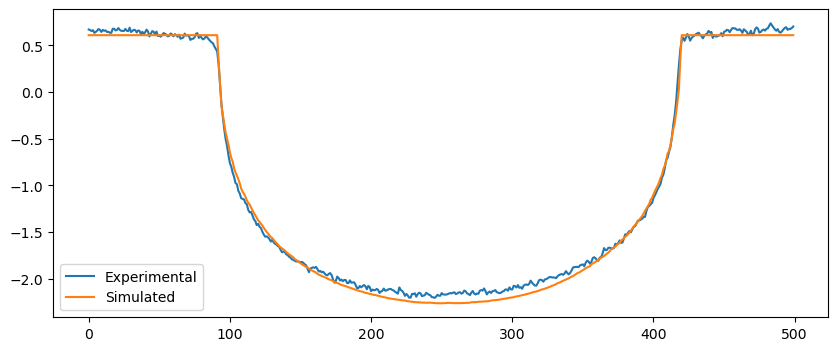

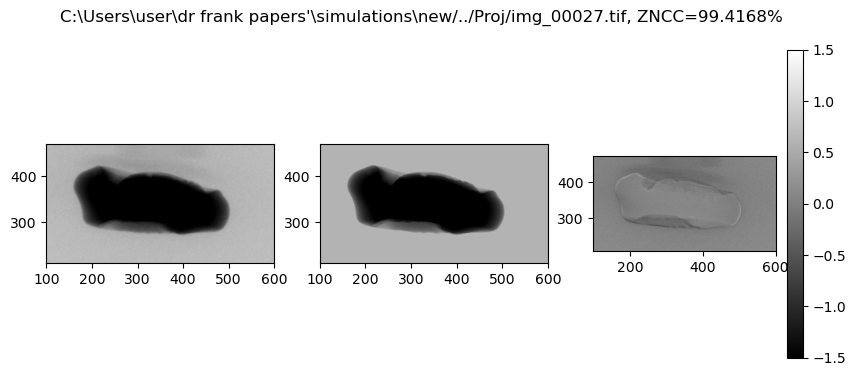

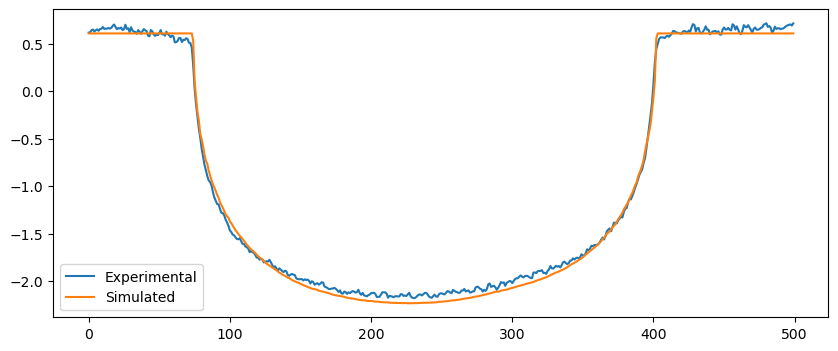

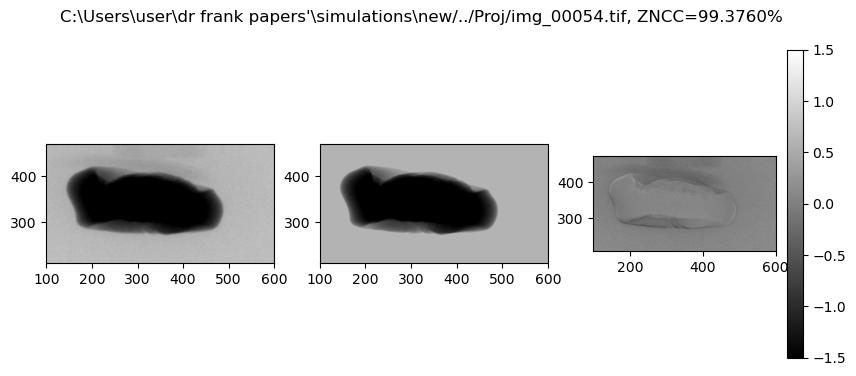

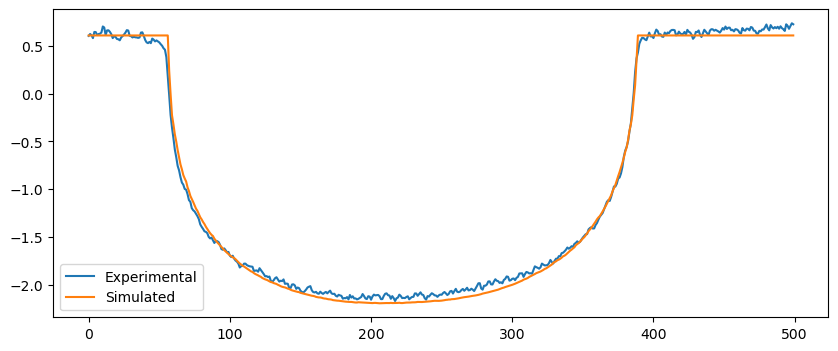

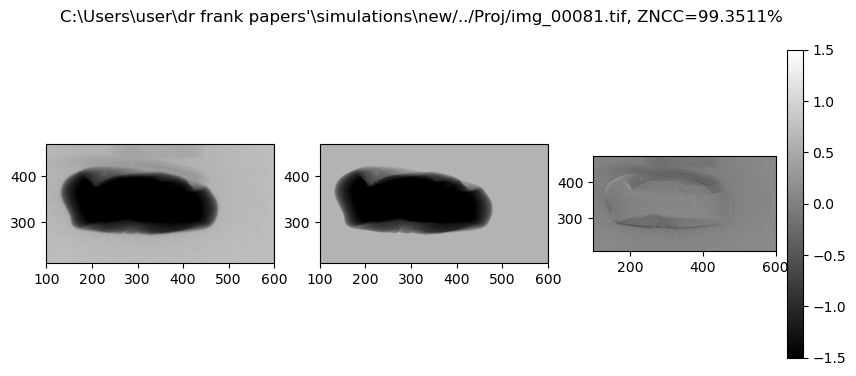

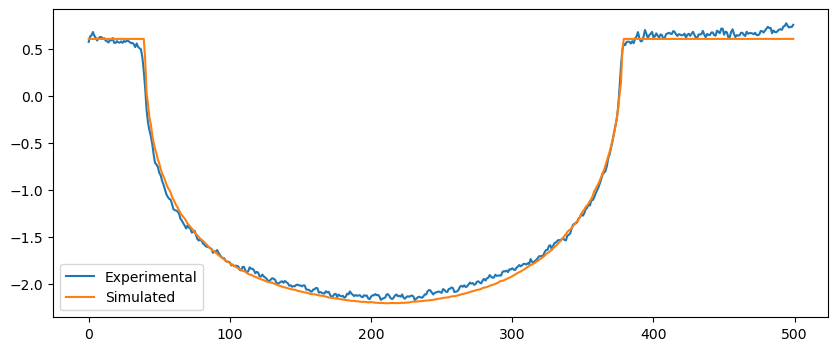

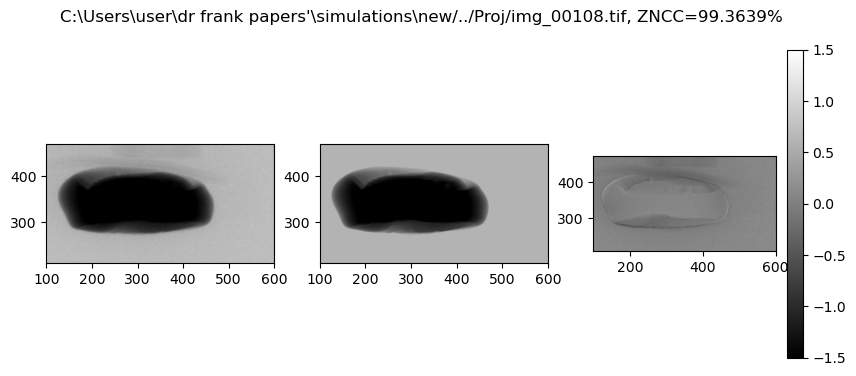

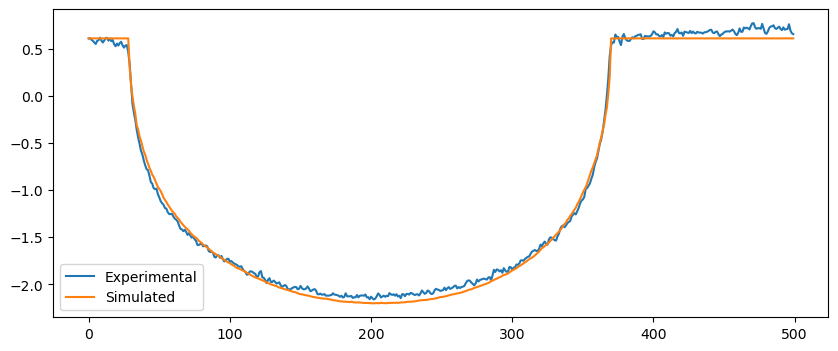

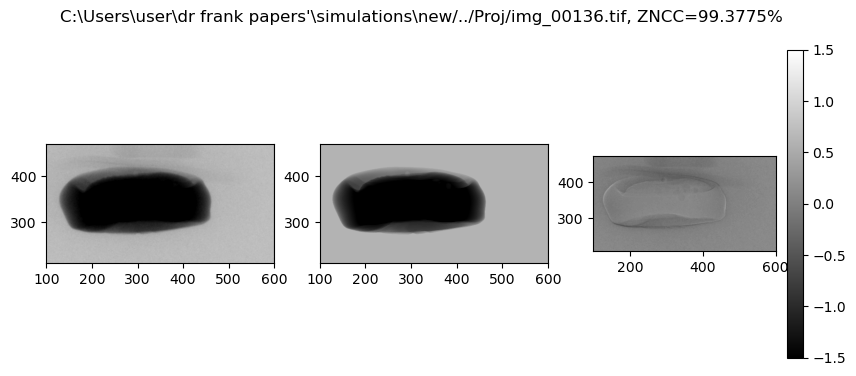

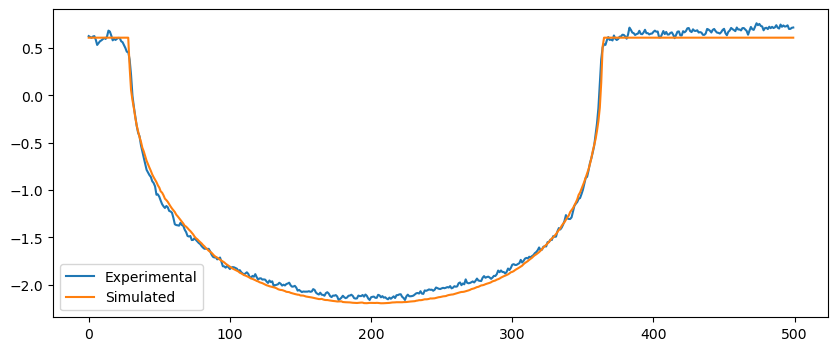

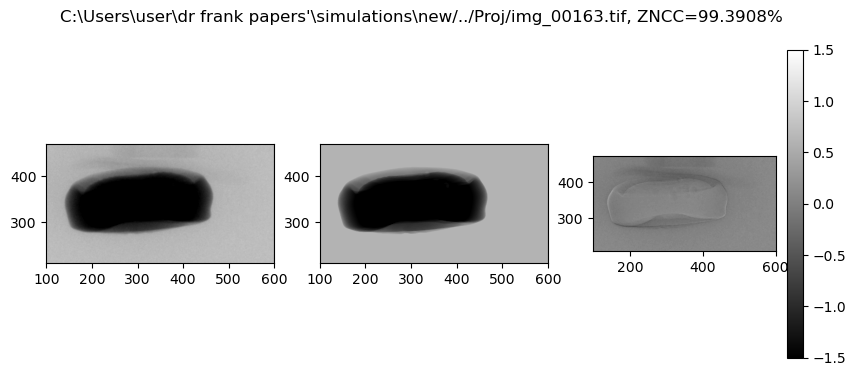

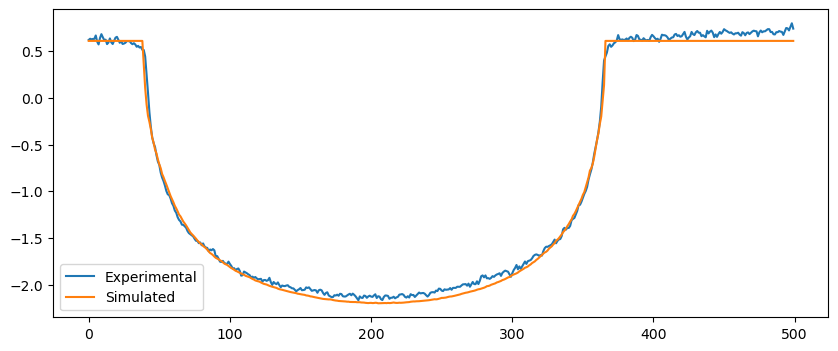

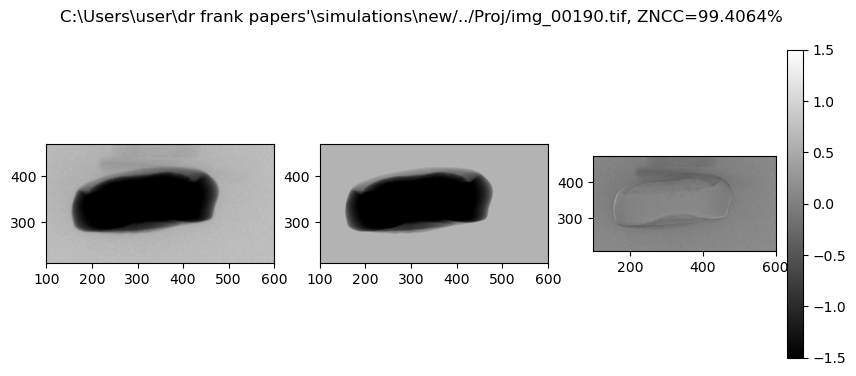

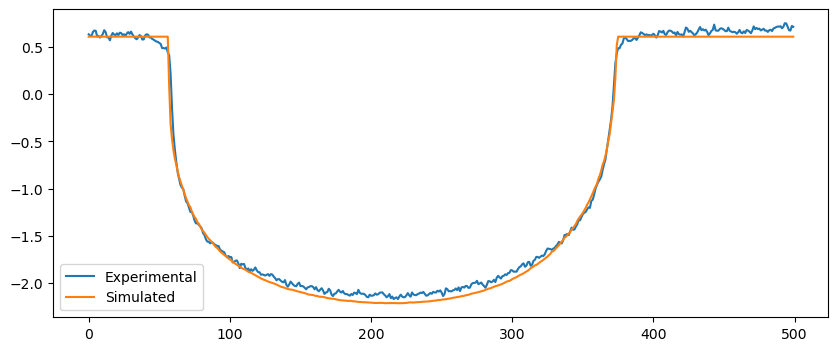

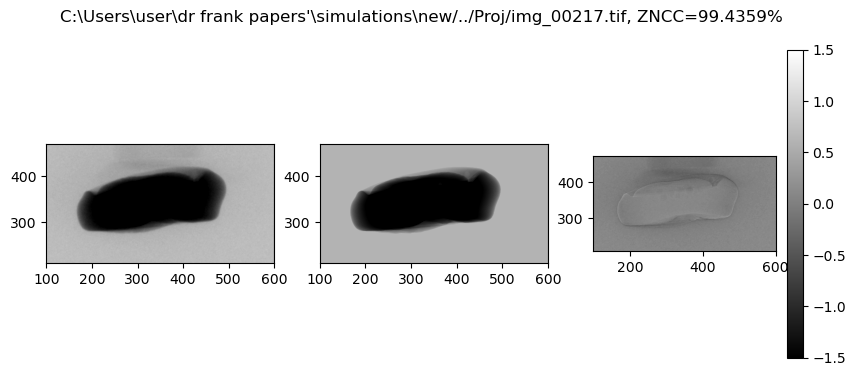

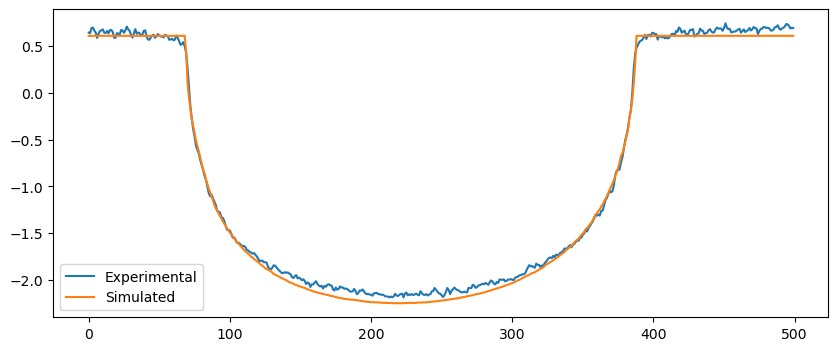

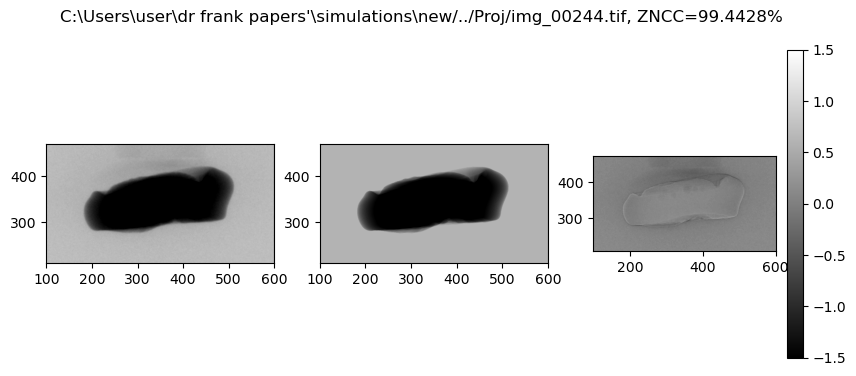

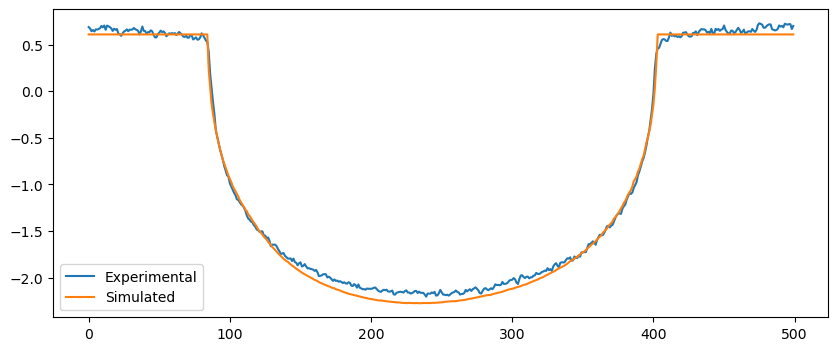

In [37]:
displayResult(x_best3)